In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

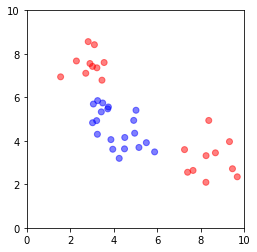

In [2]:
np.random.seed(4843750)

nums = 20
x1 = np.random.rand(nums, 2) * 3 + np.array([[3, 3]])
x2 = np.random.rand(nums//2, 2) * 3 + np.array([[7, 2]])
x3 = np.random.rand(nums//2, 2) * 3 + np.array([[1, 6]])
x = np.concatenate([x1, x2, x3])
y = np.array([-1]*nums + [1]*nums)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.5)
plt.axis('scaled')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [3]:
class SVM(object):
    def __init__(self, x, y, c, tol, iters, method):
        self.x = x
        self.y = y
        self.c = c
        self.tol = tol
        self.iters = iters
        self.alphas = np.zeros(x.shape[0])
        self.weights = np.zeros(x.shape[1])
        self.bias = 0 
        self.method = method
        return
    
    def kernel(self, xi, xj):
        if self.method=='linear':
            res = np.dot(xi, xj) 
        elif self.method == 'poly':
            res = np.power(np.dot(xi, xj) + 1, 2).sum()
        elif self.method == 'guess':
            res = np.exp(-np.power(xi-xj, 2).sum()/(2))
        else:
            res = np.dot(xi, xj)
        return res
    
    def compute_gi(self, i):
        xi, gi = self.x[i], 0
        for j in range(len(self.alphas)):
            yj, aj, xj = self.y[j], self.alphas[j], self.x[j]
            gi += yj*aj*self.kernel(xi, xj)
        gi += self.bias
        return gi
    
    def compute_ei(self, i):
        ei = self.compute_gi(i) - self.y[i] 
        return ei
    
    def compute_grand(self, i, j):
        xi, xj = self.x[i], self.x[j]
        kij = self.kernel(xi, xj)
        return kij
    
    def select_j_random(self, i):
        j = i
        while j==i:
            j = int(np.random.uniform(0, len(self.alphas)))
        return j
    
    def compute_L_H(self, ai, aj, yi, yj):
        if yi!=yj:
            L = max(0, aj - ai)
            H = min(self.c, self.c + aj - ai)
        else:
            L = max(0, aj + ai - self.c)
            H = min(self.c, aj + ai)
        return L, H
    
    def clip_alphas(self, aj_new, L, H):
        if aj_new <= L:
            aj_new = L
        elif aj_new >= H:
            aj_new = H
        return aj_new
    
    def clip_bias(self, ai_new, aj_new, bi, bj):
        b = None
        if 0 < ai_new < self.c:
                b = bi
        elif 0 < aj_new < self.c:
            b = bj
        else:
            b = (bi + bj)/2
        return b
    
    def is_violate_kkt(self, i):
        ai = self.alphas[i]
        yi = self.y[i]
        gi = self.compute_gi(i)
        c = self.c
        if (0<ai<c) and (yi*gi!=1):
            return True
        if (ai==c) and (yi*gi>1):
            return True
        if (ai==0) and (yi*gi<1):
            return True
        return False
    
    def select_i_violate_kkt(self):
        cands = list(range(len(self.alphas)))
        np.random.shuffle(cands)
        for i in cands:
            if self.is_violate_kkt(i):
                return i
        return None
    
    def select_j_from_i(self, i):
        ei = self.compute_ei(i)
        e_max = 0
        j_res = None
        for j in range(len(self.alphas)):
            if j==i:
                continue
            if self.is_violate_kkt(j) is False:
                pass
            else:
                ej = self.compute_ei(j)
                if np.abs(ei - ej) >= e_max:
                    e_max = np.abs(ei - ej)
                    j_res = j
        return j_res
                
    
    def platt_smo(self):
        i = self.select_i_violate_kkt()
        if i is None:
            return 
        j = self.select_j_from_i(i) 
        if j is None:
            return
        ai, aj = self.alphas[i], self.alphas[j]
        xi, xj = self.x[i], self.x[j]
        yi, yj = self.y[i], self.y[j]
        ei, ej = self.compute_ei(i), self.compute_ei(j)

        k11 = self.compute_grand(i, i)
        k12 = self.compute_grand(i, j)
        k21 = self.compute_grand(j, i)
        k22 = self.compute_grand(j, j)
        eta = k11 - 2*k12 + k22   
        # print((i, j), (k11, k12, k22), eta)

        L, H = self.compute_L_H(ai, aj, yi, yj)
        aj_new = aj + yj*(ei - ej)/eta

        aj_new = self.clip_alphas(aj_new, L, H)
        ai_new = ai + yi*yj*(aj - aj_new)
        # print((i, j), (ai, ai_new), (aj, aj_new))

        # if np.abs(aj_new - aj)< 0.00001:
        #     print("np.abs(aj_new - aj)< 0.00001")
        #     return 
        # print((i, j), (ai, ai_new), (aj, aj_new))

        bi = -ei - yi*k11*(ai_new - ai) - yj*k12*(aj_new - aj) + self.bias
        bj = -ej - yi*k12*(ai_new - ai) - yj*k22*(aj_new - aj) + self.bias
        b_new = self.clip_bias(ai_new, aj_new, bi, bj)
        # print((i, j), (ai, ai_new), (aj, aj_new), (b_new))

        self.alphas[i] = ai_new
        self.alphas[j] = aj_new
        self.bias = b_new
        return
    
    def run_test(self):
        i = self.select_i_violate_kkt()
        j = self.select_j_from_i(i)
        return j
    
    def run(self):
        for loop in range(self.iters):
            self.platt_smo()
            # print(np.round(self.alphas, 3))
        self.alphas = np.round(self.alphas, 3)
        return
    
    def predict(self, x_sample):
        x_label = list()
        for i in range(len(x_sample)):
            xi, gi = x_sample[i], 0
            for j in range(len(self.alphas)):
                yj, aj, xj = self.y[j], self.alphas[j], self.x[j]
                gi += yj*aj*self.kernel(xi, xj)
            gi += self.bias
            x_label.append(gi)
        # x_label = np.where(np.array(x_label)>0, 1, -1)
        return np.array(x_label)
    
    def compute_accuracy(self):
        x_label = self.predict(self.x)
        x_label = np.where(x_label>0, 1, -1)
        tp = np.sum(np.array(x_label == self.y))
        nums = len(self.x)
        acc = tp / nums
        return acc
    pass 

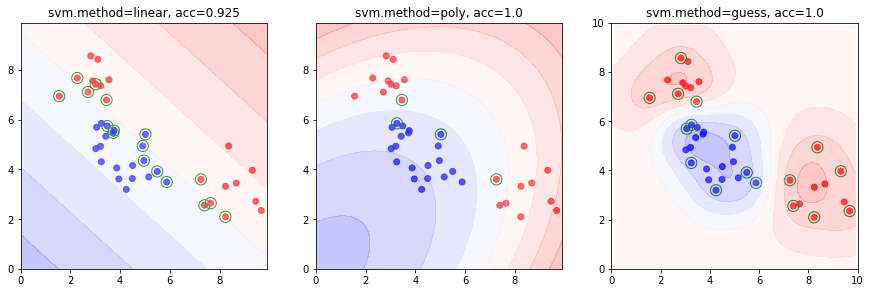

In [4]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(5)
for p, method in enumerate(['linear','poly','guess']):
    svm = SVM(x, y, c=1.0, tol=0.01, iters=200, method=method)
    svm.run()
    acc = svm.compute_accuracy()

    # print('svm.method = ', method)
    # print('svm.alphas = ', svm.alphas)
    # print('svm.acc = ', acc)

    res = svm.predict(x)

    xt = np.arange(0, 10, 0.1)
    yt = np.arange(0, 10, 0.1)
    xx, yy = np.meshgrid(xt, yt)
    zz = np.array(list(zip(xx.ravel(), yy.ravel())))
    zp = svm.predict(zz)
    zc = zp.reshape(xx.shape) 
    # zc = np.where(zc>=0, 1, -1)

    axes[p].scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.75)
    for i in range(len(svm.alphas)):
        if svm.alphas[i]>0:
            axes[p].scatter(x[i:i+1, 0], x[i:i+1, 1], c='None', edgecolors='green', s=125)
    axes[p].contourf(xx, yy, zc, cmap='bwr', alpha=0.25)
    axes[p].axis('scaled')
    axes[p].set_title(f'svm.method={method}, acc={acc}')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()